# Phonological Patterns Across Language Families
This project investigates relationships between phonological inventory size and other structural features in world languages.
It uses a typological dataset to explore the following questions:
- Do language families differ significantly in their sound inventory sizes?
- Can features like consonant clusters or vowel ratios help predict word length?
- What predicts whether a language has a phonemic vowel length distinction?

The analysis uses Python with pandas, seaborn, statsmodels, and scikit-learn.

# Step 1: Exploring Word Structure and Phonological Inventories

In [2]:
import pandas as pd

languages_df = pd.read_csv('languages.tsv', sep='\t')
forms_df = pd.read_csv('forms.tsv', sep='\t')

languages_df.head()

,isocode,name,family,inventorySize,phonVowLength,phonGeminates
0,fin,Finnish,Uralic,51,True,True
1,krl,North Karelian,Uralic,36,True,True
2,olo,Olonets Karelian,Uralic,41,True,True
3,vep,Veps,Uralic,36,False,True
4,ekk,Estonian,Uralic,48,True,True


In [3]:
forms_df.head()

,isocode,concept,form,wordLength,longestClusterLength,vowConsRatio
0,fin,EYE,silmæ,5,2,0.6875
1,fin,EAR,kɔrʋɑ,5,2,0.6875
2,fin,NOSE,nɛnæ,4,1,1.0000
3,fin,MOUTH,suː,2,1,1.0000
4,fin,TOOTH,hɑmːɑs,5,1,0.6875


## b) Enlarge languages dataframe with averaged metrics

In [4]:
merged_df = pd.merge(forms_df, languages_df, on='isocode')

avg_metrics = merged_df.groupby('isocode').agg({
    'wordLength': 'mean',
    'longestClusterLength': 'mean',
    'vowConsRatio': 'mean'
}).rename(columns={
    'wordLength': 'avgLength',
    'longestClusterLength': 'avgCluster',
    'vowConsRatio': 'avgVowRatio'
})

languages_df = pd.merge(languages_df, avg_metrics, on='isocode')
languages_df.head()

,isocode,name,family,inventorySize,phonVowLength,phonGeminates,avgLength,avgCluster,avgVowRatio
0,fin,Finnish,Uralic,51,True,True,5.401639,1.418033,1.056490
1,krl,North Karelian,Uralic,36,True,True,5.635721,1.334218,1.164874
2,olo,Olonets Karelian,Uralic,41,True,True,5.803079,1.388169,1.153064
3,vep,Veps,Uralic,36,False,True,5.344402,1.483871,0.852587
4,ekk,Estonian,Uralic,48,True,True,5.411820,1.357411,1.025670


## c) Find min/max for numerical variables

In [7]:
numerical_cols = ['inventorySize', 'avgLength', 'avgCluster', 'avgVowRatio']

for col in numerical_cols:
    min_lang = languages_df.loc[languages_df[col].idxmin(), 'name']
    max_lang = languages_df.loc[languages_df[col].idxmax(), 'name']
    print(f"{col}: Min = {min_lang}, Max = {max_lang}")

inventorySize: Min = Western Farsi, Max = Lithuanian
avgLength: Min = English, Max = Slovene
avgCluster: Min = Chuvash, Max = Lithuanian
avgVowRatio: Min = Russian, Max = Northern Pashto


## d) Visualize pairwise distributions

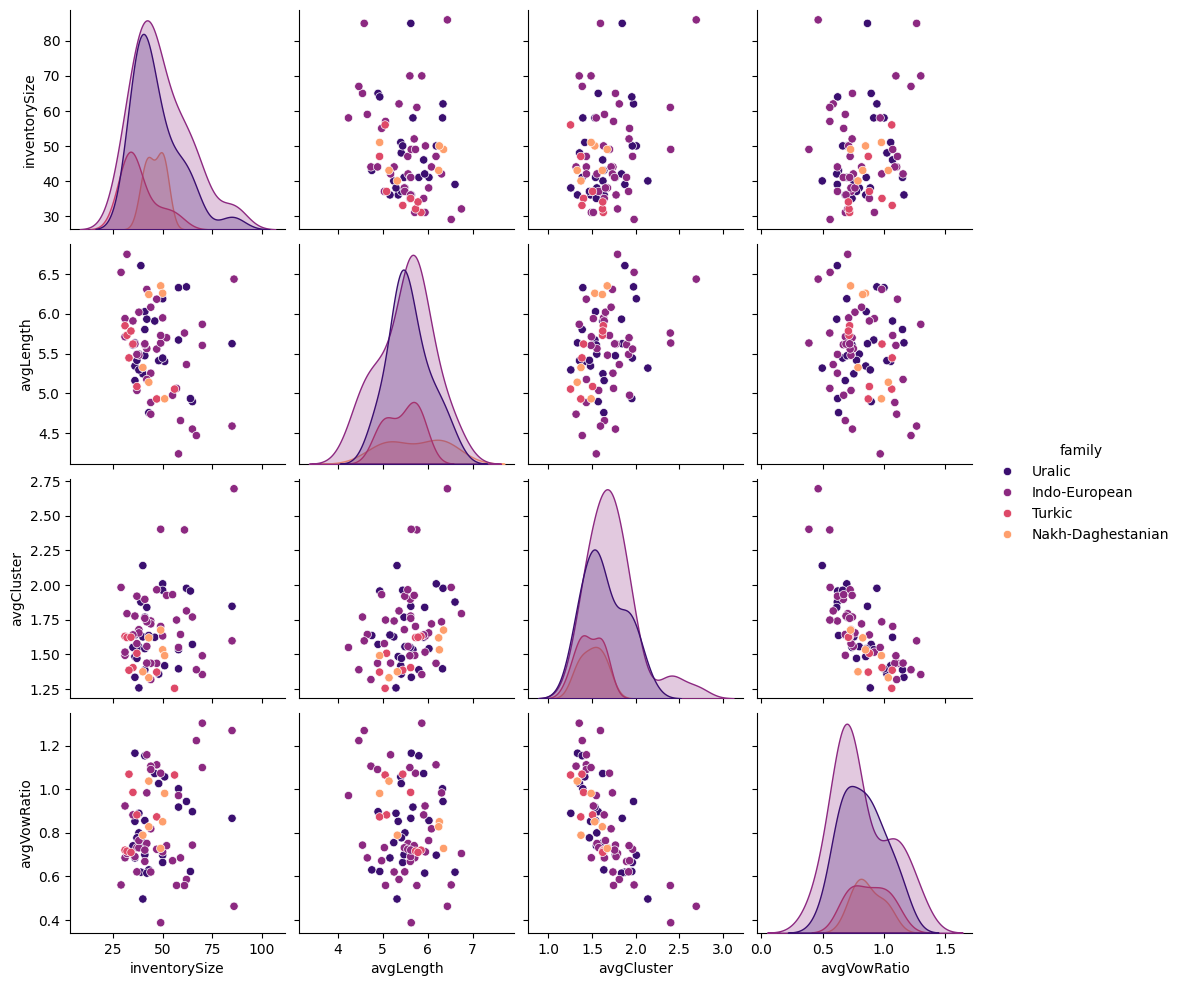

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(languages_df, 
             vars=['inventorySize', 'avgLength', 'avgCluster', 'avgVowRatio'],
             hue='family',
             palette='magma')
plt.show()

# Step 2: Do Language Families Differ in Inventory Size?

## b) Check assumptions and transform data if needed

In [14]:
from scipy import stats

families = languages_df['family'].unique()
for family in families:
    data = languages_df[languages_df['family'] == family]['inventorySize']
    stat, p = stats.shapiro(data)
    print(f"{family}: p-value = {p:.4f}")

Uralic: p-value = 0.0007
Indo-European: p-value = 0.0187
Turkic: p-value = 0.0206
Nakh-Daghestanian: p-value = 0.2695


In [16]:
stats.levene(*[languages_df[languages_df['family'] == family]['inventorySize'] 
              for family in families])

LeveneResult(statistic=np.float64(1.3863139838516603), pvalue=np.float64(0.25377204983918944))

## c) Perform the test and interpret results

In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# One-way ANOVA
model = ols('inventorySize ~ C(family)', data=languages_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq    df         F    PR(>F)
C(family)    800.698292   3.0  1.675251  0.179785
Residual   11630.288721  73.0       NaN       NaN


# Step 3: Predicting Average Word Length from Phonological Features

In [21]:
predictors = ['inventorySize', 'avgCluster', 'avgVowRatio']
target = 'avgLength'

models = {}
for pred in predictors:
    X = languages_df[pred]
    X = sm.add_constant(X)  # Adds intercept term
    model = sm.OLS(languages_df[target], X).fit()
    models[f"model_{pred}"] = model
    print(f"Model with {pred}: R-squared = {model.rsquared:.3f}")

Model with inventorySize: R-squared = 0.049
Model with avgCluster: R-squared = 0.085
Model with avgVowRatio: R-squared = 0.032


In [22]:
predictors = ['inventorySize', 'avgCluster', 'avgVowRatio']
target = 'avgLength'

models = {}
for pred in predictors:
    X = languages_df[pred]
    X = sm.add_constant(X)  # Adds intercept term
    model = sm.OLS(languages_df[target], X).fit()
    models[f"model_{pred}"] = model
    print(f"Model with {pred}: R-squared = {model.rsquared:.3f}")

Model with inventorySize: R-squared = 0.049
Model with avgCluster: R-squared = 0.085
Model with avgVowRatio: R-squared = 0.032


In [23]:
X = languages_df[predictors]
X = sm.add_constant(X)
full_model = sm.OLS(languages_df[target], X).fit()
models['full_model'] = full_model
print(f"Full model R-squared = {full_model.rsquared:.3f}")

# Compare all models
print("\nBest model based on R-squared:")
best_model = max(models.items(), key=lambda x: x[1].rsquared)
print(f"{best_model[0]}: R-squared = {best_model[1].rsquared:.3f}")

Full model R-squared = 0.239

Best model based on R-squared:
full_model: R-squared = 0.239


# Step 4: Comparing Linear Regression Models (Regularization)

In [24]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.metrics import r2_score

X = languages_df[predictors]
y = languages_df[target]

# Linear Regression
lr = LinearRegression().fit(X, y)
print(f"Linear Regression R2: {r2_score(y, lr.predict(X)):.3f}")

# Lasso Regression
lasso = Lasso(alpha=0.1).fit(X, y)
print(f"Lasso R2: {r2_score(y, lasso.predict(X)):.3f}")

# ElasticNet
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5).fit(X, y)
print(f"ElasticNet R2: {r2_score(y, elastic.predict(X)):.3f}")


Linear Regression R2: 0.239
Lasso R2: 0.049
ElasticNet R2: 0.049


# Step 5: Predicting Phonemic Vowel Length

In [27]:
X = languages_df[['inventorySize', 'avgLength', 'avgCluster', 'avgVowRatio', 'family']]
X = pd.get_dummies(X, columns=['family'], drop_first=True)
y = languages_df['phonVowLength']

In [28]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=1000).fit(X, y)
print(f"Accuracy: {logit.score(X, y):.3f}")

Accuracy: 0.805


In [29]:
coef_df = pd.DataFrame({'feature': X.columns, 'coefficient': logit.coef_[0]})
print(coef_df.sort_values('coefficient', ascending=False))

                    feature  coefficient
6             family_Uralic     0.562026
2                avgCluster     0.501433
0             inventorySize     0.095062
5             family_Turkic    -0.349440
3               avgVowRatio    -0.463963
4  family_Nakh-Daghestanian    -0.861532
1                 avgLength    -0.928342


In [30]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(LogisticRegression(max_iter=1000), X, y, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")


Cross-validation accuracy: 0.756 (±0.087)
